## Importing all the Libraries

In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import Likelihood, QuantileRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib

from datetime import timedelta
#warnings
import warnings
warnings.filterwarnings("ignore")

## Loading the Model

In [9]:
input_chunk_length = 50
output_chunk_length = 50  # Forecast horizon of 50 time steps

from pytorch_lightning.callbacks import Callback
# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]

class LossLogger(Callback):
    def __init__(self):
        self.train_loss = []
        self.val_loss = []

    # will automatically be called at the end of each epoch
    def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        self.train_loss.append(float(trainer.callback_metrics["train_loss"]))

    def on_validation_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        self.val_loss.append(float(trainer.callback_metrics["val_loss"]))


loss_logger = LossLogger()

tft_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=output_chunk_length,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=128,
    n_epochs=50,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
    pl_trainer_kwargs={"callbacks": [loss_logger]},
)


tft_model = tft_model.load("/home/vnk3019/RCP_TFT_11202023_nn.pt")


## Importing and Loading Data

In [10]:
def estimate_cold_pressure(Pmeas,Tmeas,Tcold):
    Patm = 1.01325 #bar
    
    Pcold = (Pmeas + Patm)*(Tcold+273.15)/(Tmeas + 273.15) - Patm
    
    return Pcold

def gazao_rate_model(temperature,pressure,E = 6000, tau0 = 1/3, tire_sw = 275, tire_sh = 80, tire_rim = 22.5):
    R = 8.314e-2 #L*bar/(K*mol) ideal gas constant
    T0 = 293.15 #tempoerature in kelvin
    
    #estimating the approximate volume available in the tire
    Vtire = tire_sw*(((2*tire_sw*tire_sh/100 + tire_rim*25.4)**2)*np.pi/4 - ((tire_rim*25.4)**2)*np.pi/4)*1e-6 #liters
    
    T_K = temperature + 273.15
    gazao_rate = (1/tau0)*np.exp(-E/T_K)*24*3600*pressure # in bar per day lost by diffusion
    
    # estimating the loss of mol of gas per day 
    n_est = gazao_rate*Vtire/R/T0
    
    return n_est

def repartition_static_load(total_load, WP = '1L',mount_type = 'dual'):
    #static load based on measurements at LPG for wheel force transducers
    #hard coded values based on fit parameters
    
    if WP[0] == '1':
        tire_pos_type = 'steer'
    elif WP[0] == '2' or WP[0]=='3':
        tire_pos_type = 'drive'
    elif WP[0] == '4' or WP[0]=='5':
        tire_pos_type = 'trailer'
    
    if tire_pos_type == 'steer':
        mount_type = 'single'
        wp_load =total_load*1445.5*total_load**-0.936
    elif tire_pos_type == 'drive':
        wp_load = total_load*0.041*total_load**0.0271
        if mount_type == 'xone':
            wp_load = 2*wp_load
    elif tire_pos_type == 'trailer':
        wp_load = total_load*(0.0343*np.log(total_load) - 0.3073)
        if mount_type == 'xone':
            wp_load = 2*wp_load
    return wp_load

def calc_nrg_from_classifier(clf,df,val_name):
    fts = [ 'P_avg_bar', 'avg_veh_speed_kph', 'wp_load_kg']
    df[val_name] = clf.predict(df[fts].values)    
    return df

example_df = pd.read_csv('Example_TimeSeries_Data_KR8833.bz2')

input_list = [x for x in list(example_df) if 'shear' not in x and 'nci' not in x and 'Insp_Damage' not in x]
output_list = [x for x in list(example_df) if x not in input_list]

# drum conditions 
Pinf_bar = 4.1
Load_kg = 1500
Speed_kph = 50
Start_Date = '2022-06-14'

tire_sn = 'AADB-0434'
study_type = 'DrumTesting_Condition5'

tire_type  = 'XLEZ 275/80R22.5'
#Time
freq_samp_hrs = 1 #sample per hour
rg_dates = pd.date_range(pd.to_datetime(Start_Date), pd.to_datetime(Start_Date) + timedelta(int(1e6/Speed_kph/24)),freq = str(freq_samp_hrs) + 'H')
test_df = pd.DataFrame(index = rg_dates)

# non-simulated data (although at this point temperature is estimated)

#age_days
test_df['age_days'] = (test_df.index - test_df.index[0])/timedelta(1)
#avg_speed_kph
test_df['avg_veh_speed_kph'] = Speed_kph
#casing_mileage_kms
test_df['delta_casing_mileage_kms'] = test_df.avg_veh_speed_kph*freq_samp_hrs
test_df['casing_mileage_kms'] = test_df.delta_casing_mileage_kms.cumsum()
#life_num
test_df['Life_Num'] = 1
#POS
test_df['POS'] = '1L'
#wp_load_kg
test_df['wp_load_kg'] = Load_kg
#P_avg_bar
test_df['P_avg_bar'] = Pinf_bar
#T_avg_degC
test_df['T_avg_degC'] = 50

#gazao modeling
test_df['n_rxns_per_hr'] = gazao_rate_model(test_df.T_avg_degC,test_df.P_avg_bar)/24
test_df['n_rxns_cumul'] = test_df.n_rxns_per_hr.cumsum()

#fill in the FEA metrics
rolling_radius = 498.2 #mm, simulation average among all conditions with little variation (taken from XLEZ)
Nrev_per_km = 1/(np.pi*2*rolling_radius*1e-6)
daNmm_to_kilajoule = 1e-5
clf_list = [x for x in os.listdir('./') if 'XLEZ' in x and 'NC_sidewall' in x]
clfs = [joblib.load('./' + x) for x in clf_list]
clf_name = ['_'.join(x.split('_')[1:5]) for x in clf_list]

for clf,clname in zip(clfs,clf_name):
    test_df = calc_nrg_from_classifier(clf,test_df,clname)
    if clname == 'NC_sidewall_SEelm_sumrev':
        #do a summamtion across the number of revolutions and the energy calculated, then convert the energy estimated to kilajoules
        test_df[clname] = (test_df[clname]*Nrev_per_km*test_df['avg_veh_speed_kph']*daNmm_to_kilajoule).cumsum()
test_df['Time'] = test_df.index
test_df.reset_index(drop = True, inplace = True)

In [11]:
def repartition_static_load(total_load, WP = '1L',mount_type = 'dual'):
    #static load based on measurements at LPG for wheel force transducers
    #hard coded values based on fit parameters
    
    if WP[0] == '1':
        tire_pos_type = 'steer'
    elif WP[0] == '2' or WP[0]=='3':
        tire_pos_type = 'drive'
    elif WP[0] == '4' or WP[0]=='5':
        tire_pos_type = 'trailer'
    
    if tire_pos_type == 'steer':
        mount_type = 'single'
        wp_load =total_load*1445.5*total_load**-0.936
    elif tire_pos_type == 'drive':
        wp_load = total_load*0.041*total_load**0.0271
        if mount_type == 'xone':
            wp_load = 2*wp_load
    elif tire_pos_type == 'trailer':
        wp_load = total_load*(0.0343*np.log(total_load) - 0.3073)
        if mount_type == 'xone':
            wp_load = 2*wp_load
    return wp_load


In [12]:
test_df.columns

Index(['age_days', 'avg_veh_speed_kph', 'delta_casing_mileage_kms',
       'casing_mileage_kms', 'Life_Num', 'POS', 'wp_load_kg', 'P_avg_bar',
       'T_avg_degC', 'n_rxns_per_hr', 'n_rxns_cumul', 'NC_sidewall_CVMD_AMP',
       'NC_sidewall_SEelm_sumrev', 'NC_sidewall_maxCVMD_rev', 'Time'],
      dtype='object')

In [13]:
tire_data = test_df[['age_days', 'avg_veh_speed_kph', 
       'casing_mileage_kms', 'Life_Num', 'wp_load_kg', 'P_avg_bar',
       'T_avg_degC', 'n_rxns_cumul']]
tire_data['P_avg_bar'] = 7
tire_data['T_avg_degC'] = 25


tire_data

,age_days,avg_veh_speed_kph,casing_mileage_kms,Life_Num,wp_load_kg,P_avg_bar,T_avg_degC,n_rxns_cumul
0,0.000000,50,50,1,1500,7,25,0.002361
1,0.041667,50,100,1,1500,7,25,0.004721
2,0.083333,50,150,1,1500,7,25,0.007082
3,0.125000,50,200,1,1500,7,25,0.009442
4,0.166667,50,250,1,1500,7,25,0.011803
...,...,...,...,...,...,...,...,...
19988,832.833333,50,999450,1,1500,7,25,47.185645
19989,832.875000,50,999500,1,1500,7,25,47.188006
19990,832.916667,50,999550,1,1500,7,25,47.190366
19991,832.958333,50,999600,1,1500,7,25,47.192727


## Surrogate FEM model to find Energy state and internal energy 

In [14]:
# The function that encapsulates the modeling process
def perform_modeling(df):
    # Applying the gazao_rate_model
    df['n_rxns_per_hr'] = gazao_rate_model(df.T_avg_degC, df.P_avg_bar) / 24
    df['n_rxns_cumul'] = df.n_rxns_per_hr.cumsum()

    # Constants
    rolling_radius = 498.2  # mm, simulation average among all conditions
    Nrev_per_km = 1 / (np.pi * 2 * rolling_radius * 1e-6)
    daNmm_to_kilajoule = 1e-5

    # Placeholder for actual classifier files and joblib loading process.
    clf_list = [x for x in os.listdir('./') if 'XLEZ' in x and 'NC_sidewall' in x]
    clfs = [joblib.load('./' + x) for x in clf_list]
    clf_name = ['_'.join(x.split('_')[1:5]) for x in clf_list]

    # Calculating energy from classifiers
    for clf, clname in zip(clfs, clf_name):
        df = calc_nrg_from_classifier(clf, df, clname)
        if clname == 'NC_sidewall_SEelm_sumrev':
            # Summation across the number of revolutions and the energy calculated, convert to kilajoules
            df[clname] = (df[clname] * Nrev_per_km * df['avg_veh_speed_kph'] * daNmm_to_kilajoule).cumsum()

    # Setting 'Time' column to be the index of the DataFrame
    df['Time'] = df.index
    df.reset_index(drop=True, inplace=True)

    return df

In [15]:
# Function to change tire location based on mileage and location
def change_tire_location(df, total_load, start_mileage, end_mileage, perform_modeling, new_location):
    # Selecting the rows where tire needs to be changed based on the mileage
    df_to_change = df[(df['casing_mileage_kms'] >= start_mileage) & (df['casing_mileage_kms'] <= end_mileage)]
    
    # Change the tire location for selected rows
    df.loc[df_to_change.index, 'wp_load_kg'] = repartition_static_load(total_load, WP = new_location,mount_type = 'dual')

    df = perform_modeling(df)
    index = df_to_change.index[-1]
    
    return df, index

# Assuming we have to change tire location from '1L' to '2L' between 200 and 250 kms
tire_data_changed_1 = change_tire_location(tire_data, 36000, start_mileage=0, end_mileage=1000000, perform_modeling = perform_modeling, new_location='1LO')

In [16]:
# Function to change tire location and perform time series forecasting
def change_location_and_forecast(df, total_load, start_mileage, end_mileage, new_location, tft_model):
    # Change tire location based on mileage and perform modeling
    df, index = change_tire_location(df, total_load, start_mileage, end_mileage, perform_modeling, new_location)
    
    # Prepare the DataFrame for forecasting
    df_rcp_cov = df[['Life_Num', 'NC_sidewall_CVMD_AMP', 'NC_sidewall_SEelm_sumrev',
                     'NC_sidewall_maxCVMD_rev', 'P_avg_bar', 'T_avg_degC', 'age_days',
                     'avg_veh_speed_kph', 'casing_mileage_kms', 'n_rxns_cumul',
                     'wp_load_kg']]
    
    # Create a DataFrame for the series
    df_rcp_ser = pd.DataFrame({'Column1': [1] * 50})
    
    # Convert DataFrames to TimeSeries objects
    darts_rcp_cov = TimeSeries.from_dataframe(df_rcp_cov).astype(np.float32)
    darts_rcp_ser = TimeSeries.from_dataframe(df_rcp_ser).astype(np.float32)
    
    # Forecast using the pre-trained model
    Remaining_RCP = tft_model.predict(n=darts_rcp_cov.time_index.stop-100, series=darts_rcp_ser, future_covariates=darts_rcp_cov, num_samples=10, verbose=False)
    
    return Remaining_RCP.values()[index]

# Correct function call
RCP = change_location_and_forecast(tire_data, 36000, 0, 100000, '1LO', tft_model)


In [17]:
tire_data_changed_1

(         age_days  avg_veh_speed_kph  casing_mileage_kms  Life_Num  \
 time                                                                 
 0        0.000000                 50                  50         1   
 1        0.041667                 50                 100         1   
 2        0.083333                 50                 150         1   
 3        0.125000                 50                 200         1   
 4        0.166667                 50                 250         1   
 ...           ...                ...                 ...       ...   
 19988  832.833333                 50              999450         1   
 19989  832.875000                 50              999500         1   
 19990  832.916667                 50              999550         1   
 19991  832.958333                 50              999600         1   
 19992  833.000000                 50              999650         1   
 
         wp_load_kg  P_avg_bar  T_avg_degC  n_rxns_cumul  n_rxns_per_hr  \


In [18]:
x = np.linspace(1000, 500000, 5)
RCP_reduction_list = []

for end_dist in tqdm(x):
    end_dist_value = int(end_dist)
    RCP = change_location_and_forecast(tire_data, 36000, 0, end_dist_value, '2LO', tft_model)
    RCP_reduction_list.append(float(RCP))


  0%|          | 0/5 [00:00<?, ?it/s]

In [19]:
# Define tire locations
tire_locations = ['Mileage', '1L', '2LI', '2LO', '3LI', '3LO', '4LI', '4LO', '5LI', '5LO']

# Mileage steps from 0 to 10000 with 5 steps
mileage_steps = np.linspace(100, 100000, 5)

# Initialize a DataFrame to store RCP predictions
rcp_predictions = pd.DataFrame(index=mileage_steps, columns=tire_locations)

# Iterate over each tire location and each mileage step
for location in tqdm(tire_locations, desc="Locations"):
    for end_mileage in mileage_steps:
        # Call the forecasting function for each combination of location and mileage step
        RCP = change_location_and_forecast(tire_data, 36000, 0, int(end_mileage), location, tft_model)
        
        # Assuming RCP returns a numeric value or an object from which a numeric value can be extracted
        rcp_predictions.at[end_mileage, location] = float(RCP)  # Replace RCP with the appropriate value extraction if necessary

# Display the resulting matrix
print(rcp_predictions)

Locations:   0%|          | 0/9 [00:00<?, ?it/s]

                1L       2LI       2LO       3LI       3LO       4LI  \
100.0     1.003933  1.000103  1.002777  0.997119  1.001145  1.001778   
25075.0   0.615012  0.648031  0.641642  0.633407  0.652279   0.62041   
50050.0   0.534232   0.56657  0.595563  0.556953  0.571656  0.562012   
75025.0   0.448553  0.502003  0.535613  0.555664  0.558529  0.530707   
100000.0  0.193857  0.455574  0.486328  0.526584  0.487813   0.43355   

               4LO       5LI       5LO  
100.0     0.988617  0.998023  0.996528  
25075.0   0.652336  0.642757  0.607814  
50050.0   0.604512  0.579654  0.576098  
75025.0   0.578231   0.52437   0.56525  
100000.0  0.482871  0.489652  0.521534  


In [29]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Define tire locations
tire_locations = ['1L', '2LI', '2LO', '3LI', '3LO', '4LI', '4LO', '5LI', '5LO']

# Mileage steps from 100 to 100000 with 5 steps
mileage_steps = np.linspace(100, 100000, 5)

# Initialize a DataFrame to store RCP predictions with an extra 'Mileage' column
columns = ['Mileage'] + tire_locations
rcp_predictions = pd.DataFrame(columns=columns)

# Iterate over each mileage step and each tire location
for end_mileage in tqdm(mileage_steps, desc="Mileage Steps"):
    rcp_row = {'Mileage': end_mileage}
    for location in tire_locations:
        # Call the forecasting function for each combination of location and mileage step
        RCP = change_location_and_forecast(tire_data, 36000, 0, int(end_mileage), location, tft_model)
        
        # Assuming RCP returns a numeric value or an object from which a numeric value can be extracted
        rcp_row[location] = float(RCP)  # Replace RCP with the appropriate value extraction if necessary
    
    # Append the row to the DataFrame
    rcp_predictions = rcp_predictions.append(rcp_row, ignore_index=True)

# Display the resulting DataFrame
data_dict = rcp_predictions.set_index('Mileage').T.to_dict('list')
data_dict

# Convert the provided dictionary to the desired dictionary format
data = {"Mileage": list(data_dict.keys())}
for i, loc in enumerate(tire_locations):
    data[loc] = [values[i] for values in data_dict.values()]

# Now, `data` is in the desired format
data

Mileage Steps: 100%|██████████| 5/5 [02:53<00:00, 34.68s/it]

    Mileage        1L       2LI       2LO       3LI       3LO       4LI  \
0     100.0  0.999784  0.999949  1.001649  1.003908  1.003894  1.002290   
1   25075.0  0.647332  0.674125  0.662201  0.613829  0.637669  0.627805   
2   50050.0  0.576078  0.591445  0.586863  0.616442  0.564576  0.594623   
3   75025.0  0.480965  0.544227  0.542121  0.576375  0.553442  0.536780   
4  100000.0  0.353748  0.487981  0.466537  0.441531  0.321007  0.410667   

        4LO       5LI       5LO  
0  1.000471  0.999055  0.976995  
1  0.630793  0.628214  0.635340  
2  0.593045  0.602278  0.611953  
3  0.547814  0.566359  0.536751  
4  0.497864  0.513017  0.444572  


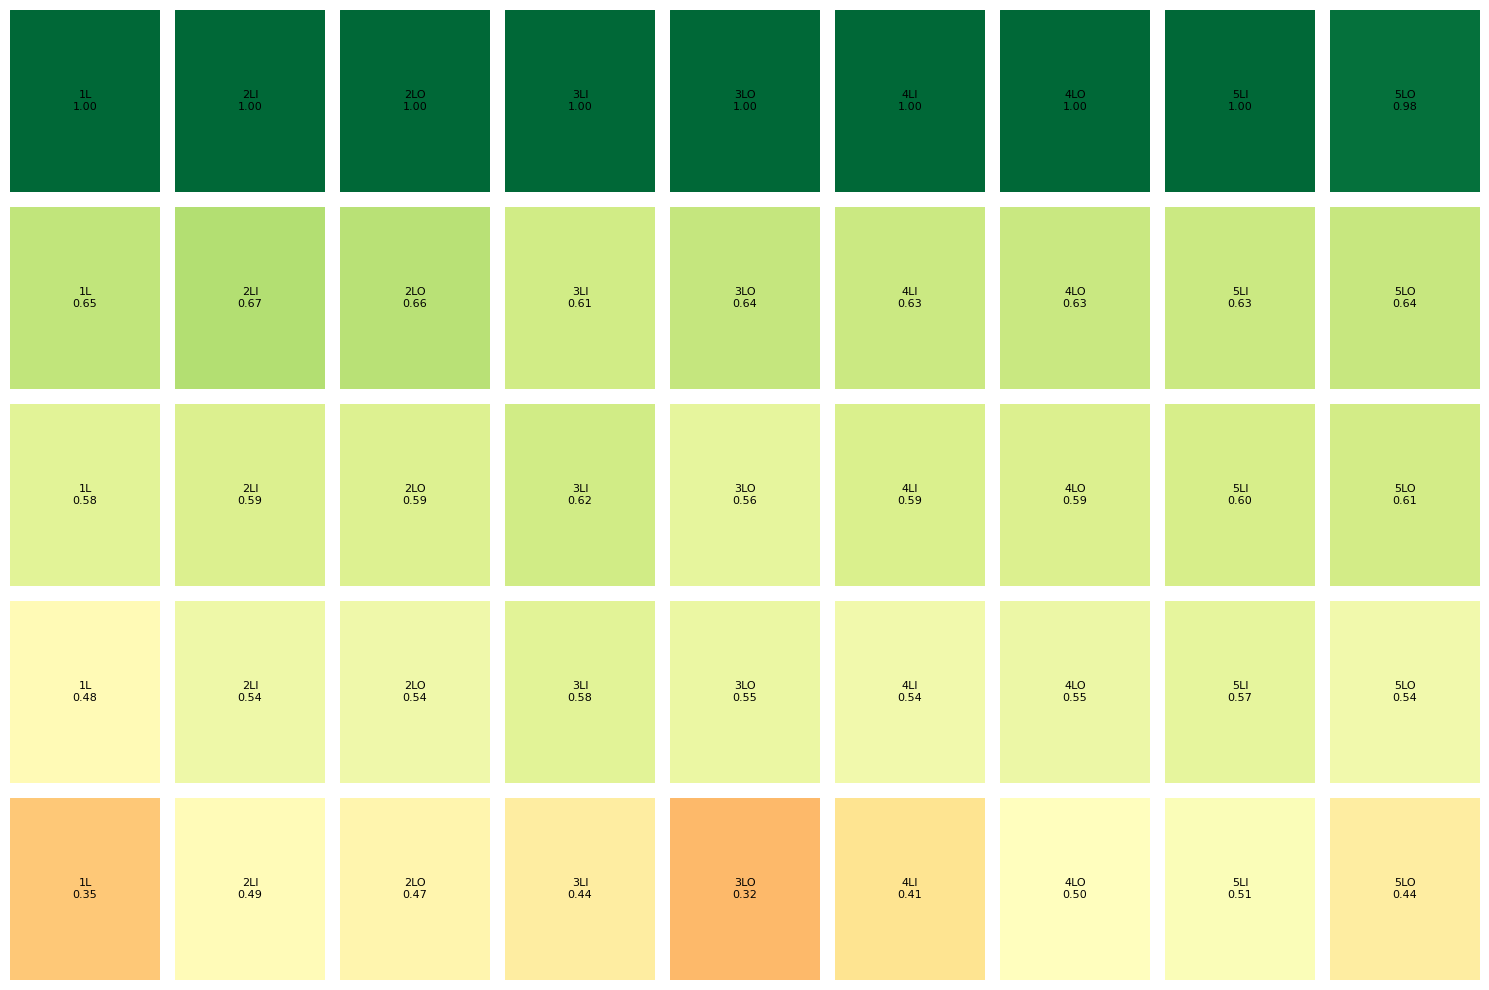

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming data has been provided in the same structure as before.

# Normalize the values to map to the colormap
norm = plt.Normalize(0, 1)
mapper = plt.cm.ScalarMappable(norm=norm, cmap='RdYlGn')

# Setting up the figure and axes
fig, axs = plt.subplots(len(data['Mileage']), len(data) - 1, figsize=(15, 10))

# Loop through each mileage step
for i, mileage in enumerate(data['Mileage']):
    for j, (location, values) in enumerate(data.items()):
        if location == 'Mileage':
            continue  # Skip the mileage column
        
        # Get the value corresponding to the current mileage step
        val = values[i]
        
        # Get the color from the color map
        color = mapper.to_rgba(val)
        
        # Plot the colored cell
        axs[i, j - 1].add_patch(plt.Rectangle((0, 0), 1, 1, color=color))
        axs[i, j - 1].text(0.5, 0.5, f'{location}\n{val:.2f}', ha='center', va='center', fontsize=8, color='black')
        
        # Turn off the axis
        axs[i, j - 1].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
